<a href="https://www.kaggle.com/code/joostyoshi/feature-importances-per-emotion?scriptVersionId=185813307" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 43.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 57.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 55.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 66.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 9.8 MB/s eta 0:00:00
  Created wheel for dash-cytoscape: filename=dash_cytoscape-1.0.1-py3-none-any.whl size=4010600 sha256=045dec4cbce70a391da704a97ae2dcd2ea14f84f645154d120b0b90fd526964b
  Stored in directory: /root/.cache/pip/wheels/2b/86/e6/a00e9295bb80ac2d86b93b9cbf5ba1ae78e9f739d75398e41f
Successfully built dash-cytoscape


In [2]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, precision_recall_fscore_support
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from interpret import show
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

In [3]:
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    os.chdir('/kaggle/input/data-cusser')

In [4]:
def createGlassbox(file,excludeCols=['path'],splits_exist =False, split_prefix="", label_col="emotion"):
    if isinstance(file, str):
        df = pd.read_csv(file, index_col=False)
    else:
        df = file

    df.reset_index(drop=True, inplace=True)
    df = df.drop(columns=excludeCols)
    unique_subjects = df['ActorID'].unique()

    if(splits_exist):
        val_df=pd.read_csv(split_prefix+"_test_df.csv")
        purt_df=pd.read_csv(split_prefix+"_val_df.csv")
        train_df=pd.read_csv(split_prefix+"_train_df.csv")
        train_subjects=train_df["ActorID"].unique()
        val1 = purt_df["ActorID"].unique()
        val2 = val_df["ActorID"].unique()
        temp_subject = val1 + val2
    train_subjects, temp_subjects = train_test_split(unique_subjects, test_size=0.3, random_state=42)

    # Step 3: Create DataFrames for each split based on the subject IDs
    train_df = df[df['ActorID'].isin(train_subjects)]
    test_df = df[df['ActorID'].isin(temp_subjects)]

    x_train = train_df.drop(columns=[label_col, 'ActorID'])
    y_train = train_df[label_col]
    x_test = test_df.drop(columns=[label_col, 'ActorID'])
    y_test = test_df[label_col]

    ebm = ExplainableBoostingClassifier()
    ebm.fit(x_train, y_train)
    

    return ebm, x_test, y_test, test_df['ActorID']


In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curve(ebm, x_test, y_test):
    classes = ebm.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    y_score = ebm.decision_function(x_test)
    
    fpr, tpr, roc_auc = {}, {}, {}
    for i, label in enumerate(classes):
        fpr[label], tpr[label], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(10, 8))
    for label in classes:
        plt.plot(fpr[label], tpr[label], label=f'{label} (area = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for each Emotion')
    plt.legend(loc="lower right")
    plt.show()


In [6]:
from sklearn.metrics import classification_report

def plot_accuracy_report(detailed_accuracy_report, sort_metric='f1-score'):
    # Extract labels and metrics from the report
    labels = list(detailed_accuracy_report.keys())
    metrics = {
        'precision': [],
        'recall': [],
        'f1-score': [],
        'accuracy': [],
        'true positives': [],
        'false positives': [],
        'false negatives': [],
        'true negatives': []
    }
    
    # Fill the metrics lists
    for label in labels:
        metrics['precision'].append(detailed_accuracy_report[label]['precision'])
        metrics['recall'].append(detailed_accuracy_report[label]['recall'])
        metrics['f1-score'].append(detailed_accuracy_report[label]['f1-score'])
        metrics['accuracy'].append(detailed_accuracy_report[label]['accuracy'])
        metrics['true positives'].append(detailed_accuracy_report[label]['true positives'])
        metrics['false positives'].append(detailed_accuracy_report[label]['false positives'])
        metrics['false negatives'].append(detailed_accuracy_report[label]['false negatives'])
        metrics['true negatives'].append(detailed_accuracy_report[label]['true negatives'])
    
    # Sort data based on the chosen metric
    sort_index = np.argsort(metrics[sort_metric])[::-1]  # Reverse to get descending order
    for key in metrics:
        metrics[key] = [metrics[key][i] for i in sort_index]
    sorted_labels = [labels[i] for i in sort_index]

    # Set up the figure and axes
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    axs = axs.ravel()

    # Titles for the subplots
    titles = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'True Positives', 'False Positives', 'False Negatives', 'True Negatives']

    # Create bar plots for each metric
    for i, (metric, values) in enumerate(metrics.items()):
        axs[i].bar(sorted_labels, values, color=plt.cm.viridis(np.linspace(0.3, 0.7, len(sorted_labels))))
        axs[i].set_title(titles[i])
        axs[i].set_ylim(0, max(values) + (0.1 * max(values)))  # Add some space on top
        for j, value in enumerate(values):
            axs[i].text(j, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [7]:
def generate_detailed_accuracy_report(ebm, x_test, y_test):
    # Predict labels for the test set
    y_pred = ebm.predict(x_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=ebm.classes_)

    # Extracting TP, FP, FN for each class for detailed accuracy calculations
    TPs = cm.diagonal()
    FPs = cm.sum(axis=0) - TPs
    FNs = cm.sum(axis=1) - TPs
    TNs = cm.sum() - (TPs + FPs + FNs)

    # Precision, recall, f1-score for each class
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

    # Calculate accuracy for each class
    accuracies = TPs / (TPs + FPs + FNs)

    # Prepare the detailed report
    detailed_report = {}
    for i, label in enumerate(ebm.classes_):
        detailed_report[label] = {
            "precision": precision[i],
            "recall": recall[i],
            "f1-score": f1_score[i],
            "support": support[i],
            "accuracy": accuracies[i],
            "true positives": TPs[i],
            "false positives": FPs[i],
            "false negatives": FNs[i],
            "true negatives": TNs[i]
        }

    return detailed_report

In [8]:
def get_local_explanations(ebm, x_test, y_test, target_emotion):
    # Predict labels for the test set
    y_pred = ebm.predict(x_test)

    # Filter for instances where predicted label is 'angry'
    angry_indices = (y_pred == target_emotion)
    angry_x_test = x_test[angry_indices]
    angry_y_test = y_test[angry_indices]

    # Store local explanations
    local_explanations = []
    explanation_data = []

    # Iterate over each 'angry' instance to get local explanations
    for index, row in angry_x_test.iterrows():
        # Get local explanation for the specific instance
        local_explanation = ebm.explain_local(row.to_frame().transpose(), angry_y_test.loc[index])
        local_explanations.append(local_explanation)
        
        # Access and store the raw explanation data for all visualizations
        explanation_details = local_explanation.data(-1)
        explanation_data.append(explanation_details)

    return local_explanations, explanation_data

In [9]:
from interpret import show

def display_global_explanation(ebm):
    global_explanation = ebm.explain_global()
    show(global_explanation)
    return global_explanation.data()

In [10]:
def plot_accuracy_report(detailed_accuracy_report):
    # Extract labels and metrics from the report
    labels = list(detailed_accuracy_report.keys())
    metrics = {
        'precision': [],
        'recall': [],
        'f1-score': [],
        'accuracy': [],
        'true positives': [],
        'false positives': [],
        'false negatives': [],
        'true negatives': []
    }
    
    # Fill the metrics lists
    for label in labels:
        metrics['precision'].append(detailed_accuracy_report[label]['precision'])
        metrics['recall'].append(detailed_accuracy_report[label]['recall'])
        metrics['f1-score'].append(detailed_accuracy_report[label]['f1-score'])
        metrics['accuracy'].append(detailed_accuracy_report[label]['accuracy'])
        metrics['true positives'].append(detailed_accuracy_report[label]['true positives'])
        metrics['false positives'].append(detailed_accuracy_report[label]['false positives'])
        metrics['false negatives'].append(detailed_accuracy_report[label]['false negatives'])
        metrics['true negatives'].append(detailed_accuracy_report[label]['true negatives'])
    
    # Set up the figure and axes
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    axs = axs.ravel()

    # Titles for the subplots
    titles = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'True Positives', 'False Positives', 'False Negatives', 'True Negatives']

    # Create bar plots for each metric
    for i, (metric, values) in enumerate(metrics.items()):
        axs[i].bar(labels, values, color=plt.cm.viridis(np.linspace(0.3, 0.7, len(labels))))
        axs[i].set_title(titles[i])
        axs[i].set_ylim(0, max(values) + (0.1 * max(values)))  # Add some space on top
        for j, value in enumerate(values):
            axs[i].text(j, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [11]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import mode

# Helper function to build the contributions dictionary
def build_contributions_dict(explanation_data):
    contributions_dict = defaultdict(list)
    for explanation in explanation_data:
        for score, name in zip(explanation['specific'][0]['scores'], explanation['specific'][0]['names']):
            contributions_dict[name].append(score[0])
    return contributions_dict

# Calculate mean contributions
def calculate_mean_contributions(contributions_dict):
    return {name: np.mean(scores) for name, scores in contributions_dict.items()}

# Calculate median contributions
def calculate_median_contributions(contributions_dict):
    return {name: np.median(scores) for name, scores in contributions_dict.items()}

# Calculate mode contributions
def calculate_mode_contributions(contributions_dict):
    return {name: mode(scores)[0] for name, scores in contributions_dict.items()}


# Calculate mode contributions
def calculate_sum_contributions(contributions_dict):
    return {name: np.sum(scores) for name, scores in contributions_dict.items()}

In [12]:
crema_ebm, crema_x_test, crema_y_test, crema_test_df = createGlassbox("data/opensmileDF_crema.csv",  excludeCols = ["path","Unnamed: 0"],splits_exist =True, split_prefix="data/crema")

/opt/conda/lib/python3.10/site-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


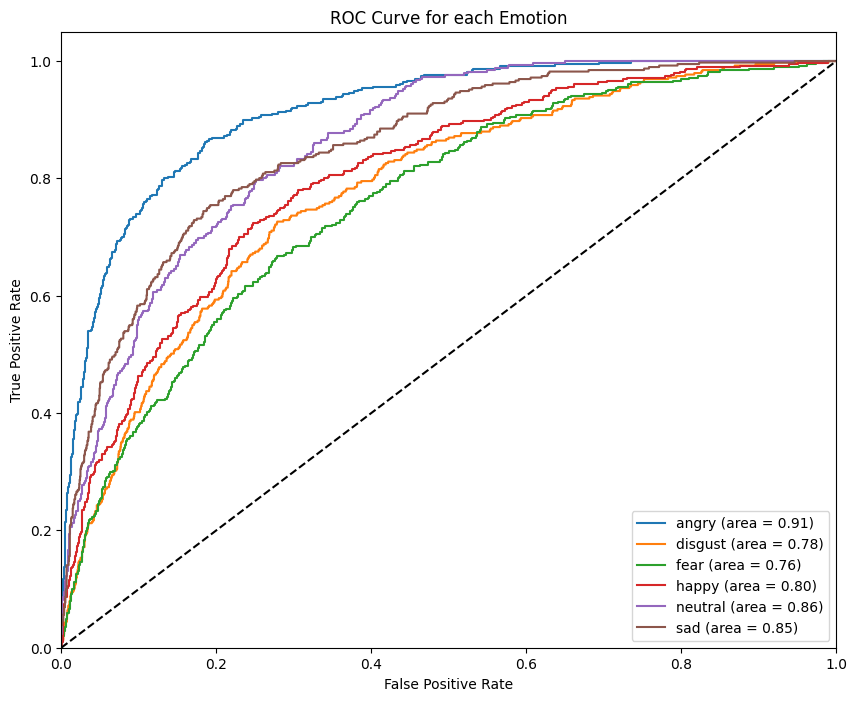

In [13]:
plot_roc_curve(crema_ebm, crema_x_test, crema_y_test)

In [14]:
# Usage
# Assuming crema_ebm, crema_x_test, and crema_y_test are defined and contain your EBM model and test sets respectively
detailed_accuracy_report = generate_detailed_accuracy_report(crema_ebm, crema_x_test, crema_y_test)
for label, metrics in detailed_accuracy_report.items():
    print(f"Metrics for {label}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Metrics for angry:
  precision: 0.6336
  recall: 0.7340
  f1-score: 0.6801
  support: 391.0000
  accuracy: 0.5153
  true positives: 287.0000
  false positives: 166.0000
  false negatives: 104.0000
  true negatives: 1733.0000
Metrics for disgust:
  precision: 0.4400
  recall: 0.3939
  f1-score: 0.4157
  support: 391.0000
  accuracy: 0.2624
  true positives: 154.0000
  false positives: 196.0000
  false negatives: 237.0000
  true negatives: 1703.0000
Metrics for fear:
  precision: 0.4781
  recall: 0.3350
  f1-score: 0.3940
  support: 391.0000
  accuracy: 0.2453
  true positives: 131.0000
  false positives: 143.0000
  false negatives: 260.0000
  true negatives: 1756.0000
Metrics for happy:
  precision: 0.4694
  recall: 0.4706
  f1-score: 0.4700
  support: 391.0000
  accuracy: 0.3072
  true positives: 184.0000
  false positives: 208.0000
  false negatives: 207.0000
  true negatives: 1691.0000
Metrics for neutral:
  precision: 0.4723
  recall: 0.5851
  f1-score: 0.5227
  support: 335.0000
  

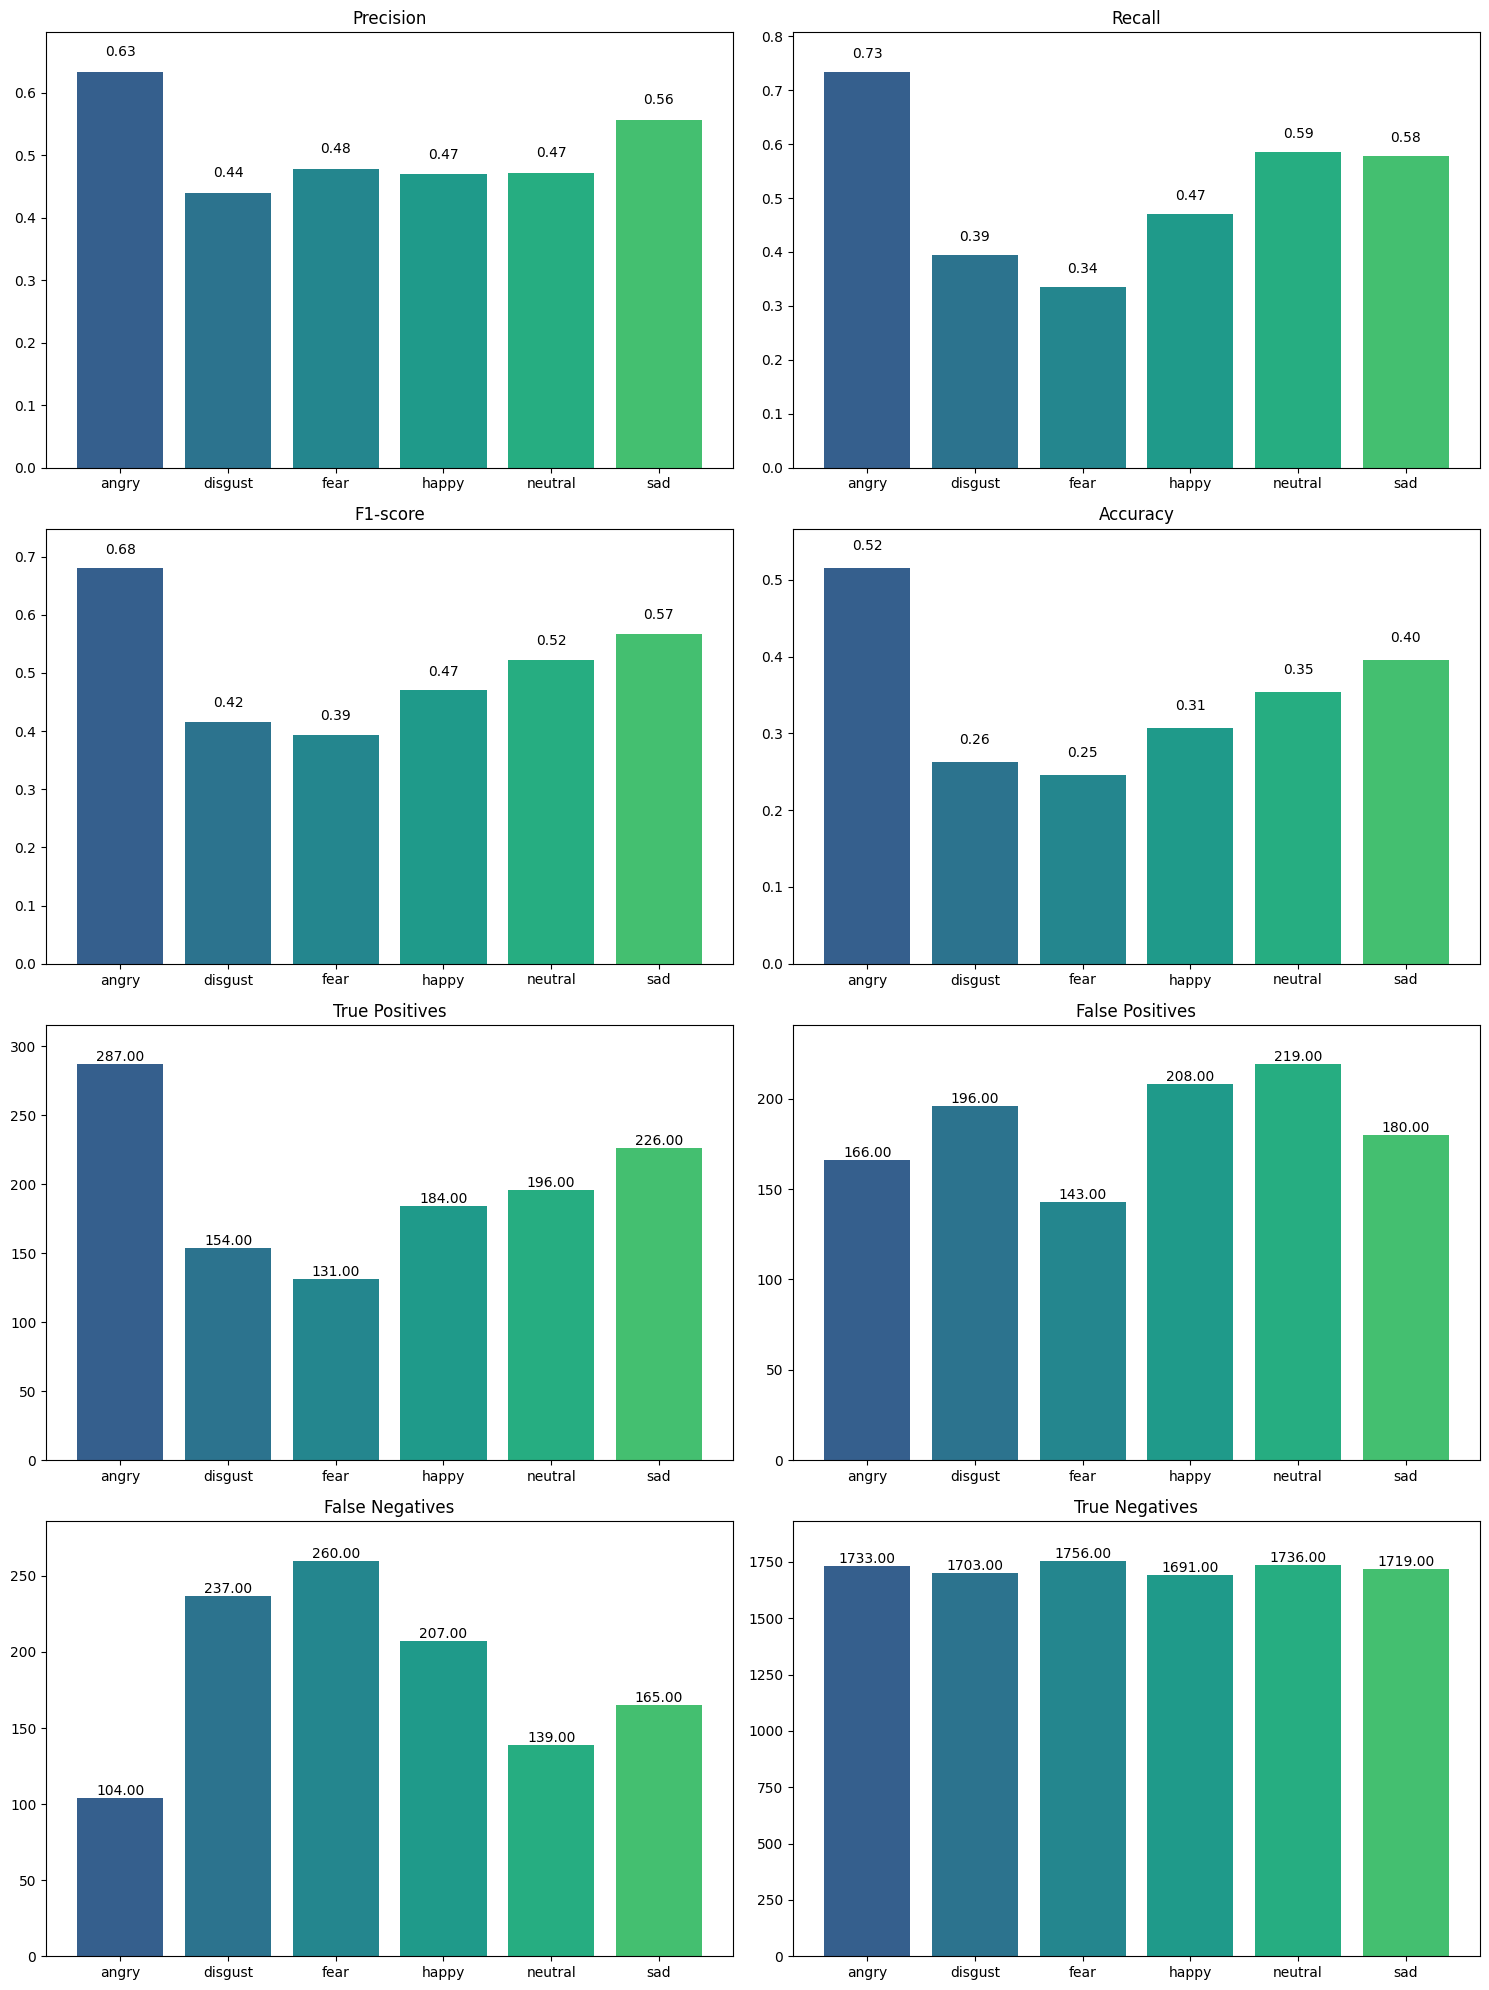

In [15]:
plot_accuracy_report(detailed_accuracy_report)

In [16]:
crema_local_explanations_angry, crema_explanation_data_angry = get_local_explanations(crema_ebm, crema_x_test, crema_y_test, 'angry')

In [17]:
contributions_dict_crema_angry = build_contributions_dict(crema_explanation_data_angry)

In [18]:
emodb_opensmile_ebm, emodb_x_test, emodb_y_test, emodb_test_df = createGlassbox(
    "data/opensmileDF_emodb.csv",
    excludeCols=["Path", "Filename", "Sex", "Age", "Unnamed: 0"],
    label_col="Emotion"
)

/opt/conda/lib/python3.10/site-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


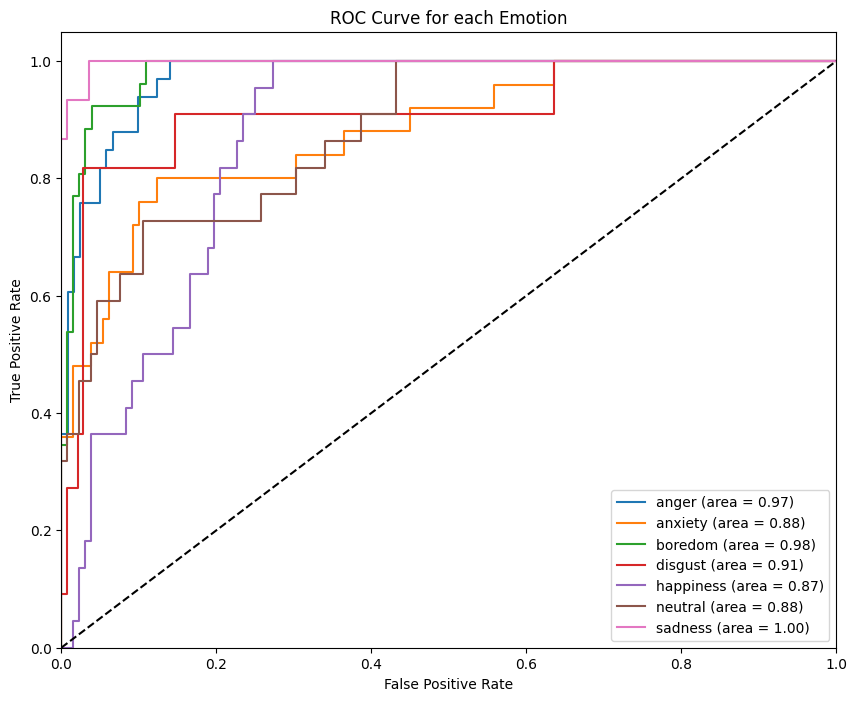

In [19]:
plot_roc_curve(emodb_opensmile_ebm, emodb_x_test, emodb_y_test)

In [20]:
# Generating a detailed accuracy report for the emodb EBM model
detailed_accuracy_report_emodb = generate_detailed_accuracy_report(emodb_opensmile_ebm, emodb_x_test, emodb_y_test)
for label, metrics in detailed_accuracy_report_emodb.items():
    print(f"Metrics for {label}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Metrics for anger:
  precision: 0.9231
  recall: 0.7273
  f1-score: 0.8136
  support: 33.0000
  accuracy: 0.6857
  true positives: 24.0000
  false positives: 2.0000
  false negatives: 9.0000
  true negatives: 119.0000
Metrics for anxiety:
  precision: 0.5455
  recall: 0.4800
  f1-score: 0.5106
  support: 25.0000
  accuracy: 0.3429
  true positives: 12.0000
  false positives: 10.0000
  false negatives: 13.0000
  true negatives: 119.0000
Metrics for boredom:
  precision: 0.7917
  recall: 0.7308
  f1-score: 0.7600
  support: 26.0000
  accuracy: 0.6129
  true positives: 19.0000
  false positives: 5.0000
  false negatives: 7.0000
  true negatives: 123.0000
Metrics for disgust:
  precision: 0.6250
  recall: 0.4545
  f1-score: 0.5263
  support: 11.0000
  accuracy: 0.3571
  true positives: 5.0000
  false positives: 3.0000
  false negatives: 6.0000
  true negatives: 140.0000
Metrics for happiness:
  precision: 0.7000
  recall: 0.6364
  f1-score: 0.6667
  support: 22.0000
  accuracy: 0.5000
  tr

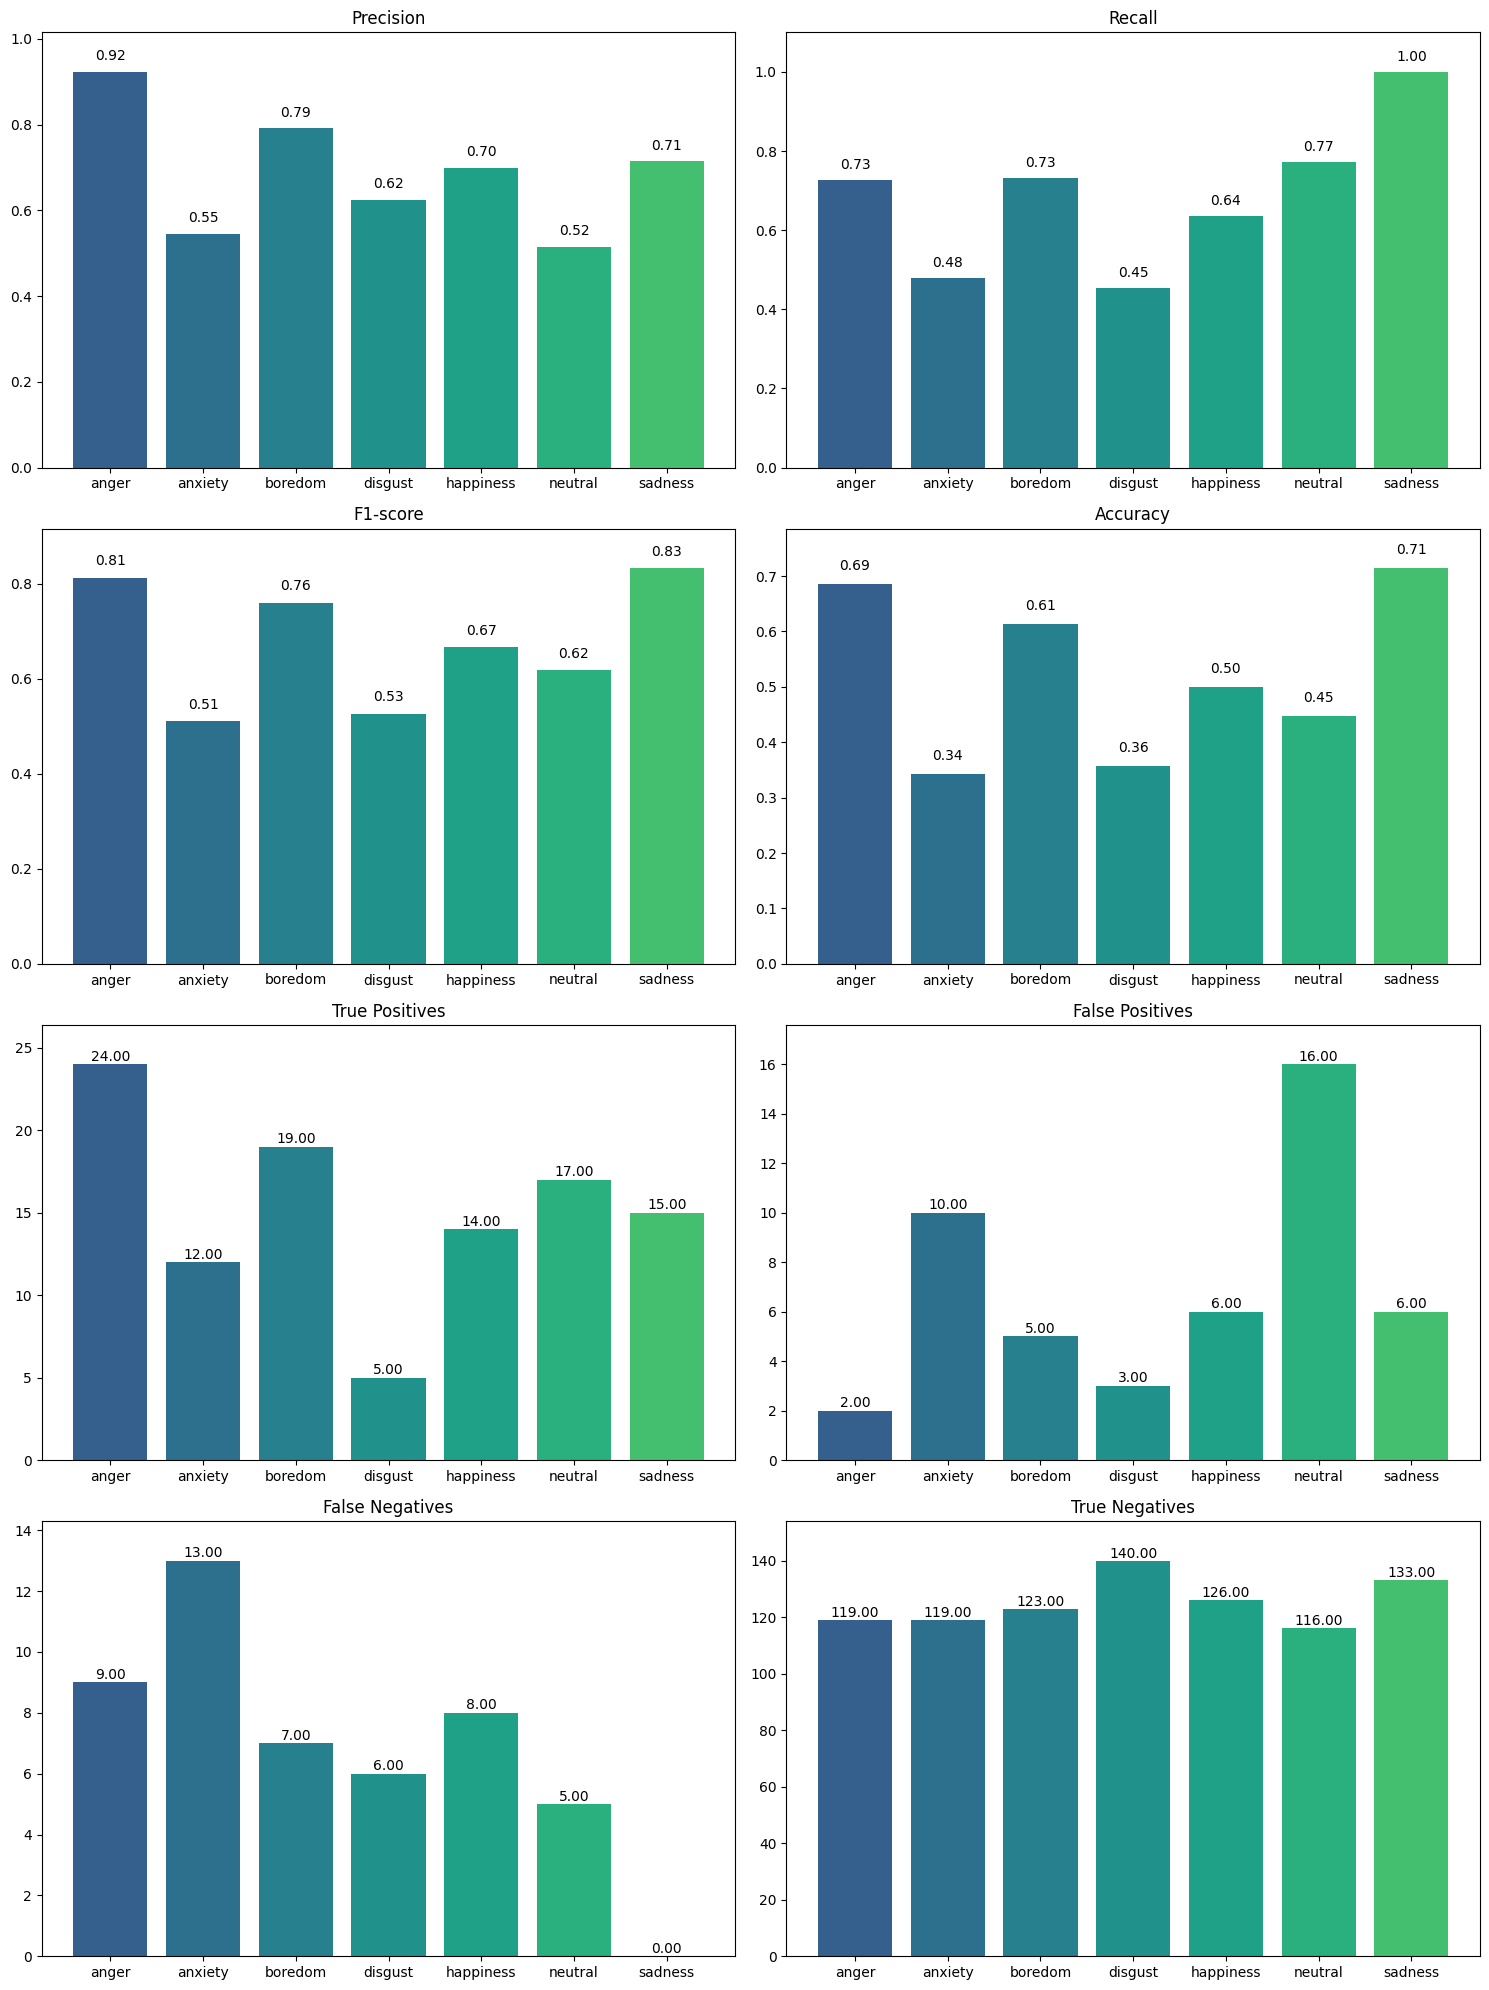

In [21]:
plot_accuracy_report(detailed_accuracy_report_emodb)

In [22]:
emodb_local_explanations_angry, emodb_explanation_data_angry = get_local_explanations(emodb_opensmile_ebm, emodb_x_test, emodb_y_test, 'anger')
# Example usage for building and plotting feature contributions for emodb
contributions_dict_emodb_angry = build_contributions_dict(emodb_explanation_data_angry)

In [23]:
# Creating the Glassbox model for the beasc dataset
beasc_opensmile_ebm, beasc_x_test, beasc_y_test, beasc_test_df = createGlassbox(
    "data/opensmileDF_beasc.csv",
    excludeCols=["Sentence", "Repetition", "Gender", "Path", "Unnamed: 0"],
    label_col="Emotion"
)

/opt/conda/lib/python3.10/site-packages/interpret/glassbox/_ebm/_ebm.py:999: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


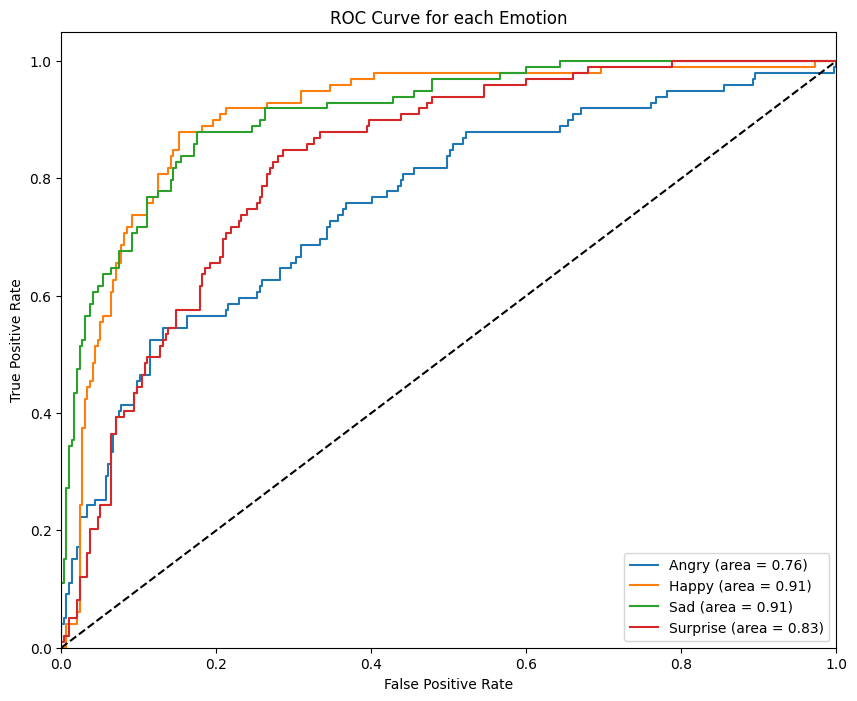

In [24]:
# Plotting ROC curve for the EBM model using the beasc dataset
plot_roc_curve(beasc_opensmile_ebm, beasc_x_test, beasc_y_test)

In [25]:
# Generating a detailed accuracy report for the beasc EBM model
detailed_accuracy_report_beasc = generate_detailed_accuracy_report(beasc_opensmile_ebm, beasc_x_test, beasc_y_test)
for label, metrics in detailed_accuracy_report_beasc.items():
    print(f"Metrics for {label}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Metrics for Angry:
  precision: 0.5854
  recall: 0.4848
  f1-score: 0.5304
  support: 99.0000
  accuracy: 0.3609
  true positives: 48.0000
  false positives: 34.0000
  false negatives: 51.0000
  true negatives: 263.0000
Metrics for Happy:
  precision: 0.7115
  recall: 0.7475
  f1-score: 0.7291
  support: 99.0000
  accuracy: 0.5736
  true positives: 74.0000
  false positives: 30.0000
  false negatives: 25.0000
  true negatives: 267.0000
Metrics for Sad:
  precision: 0.7103
  recall: 0.7677
  f1-score: 0.7379
  support: 99.0000
  accuracy: 0.5846
  true positives: 76.0000
  false positives: 31.0000
  false negatives: 23.0000
  true negatives: 266.0000
Metrics for Surprise:
  precision: 0.5437
  recall: 0.5657
  f1-score: 0.5545
  support: 99.0000
  accuracy: 0.3836
  true positives: 56.0000
  false positives: 47.0000
  false negatives: 43.0000
  true negatives: 250.0000


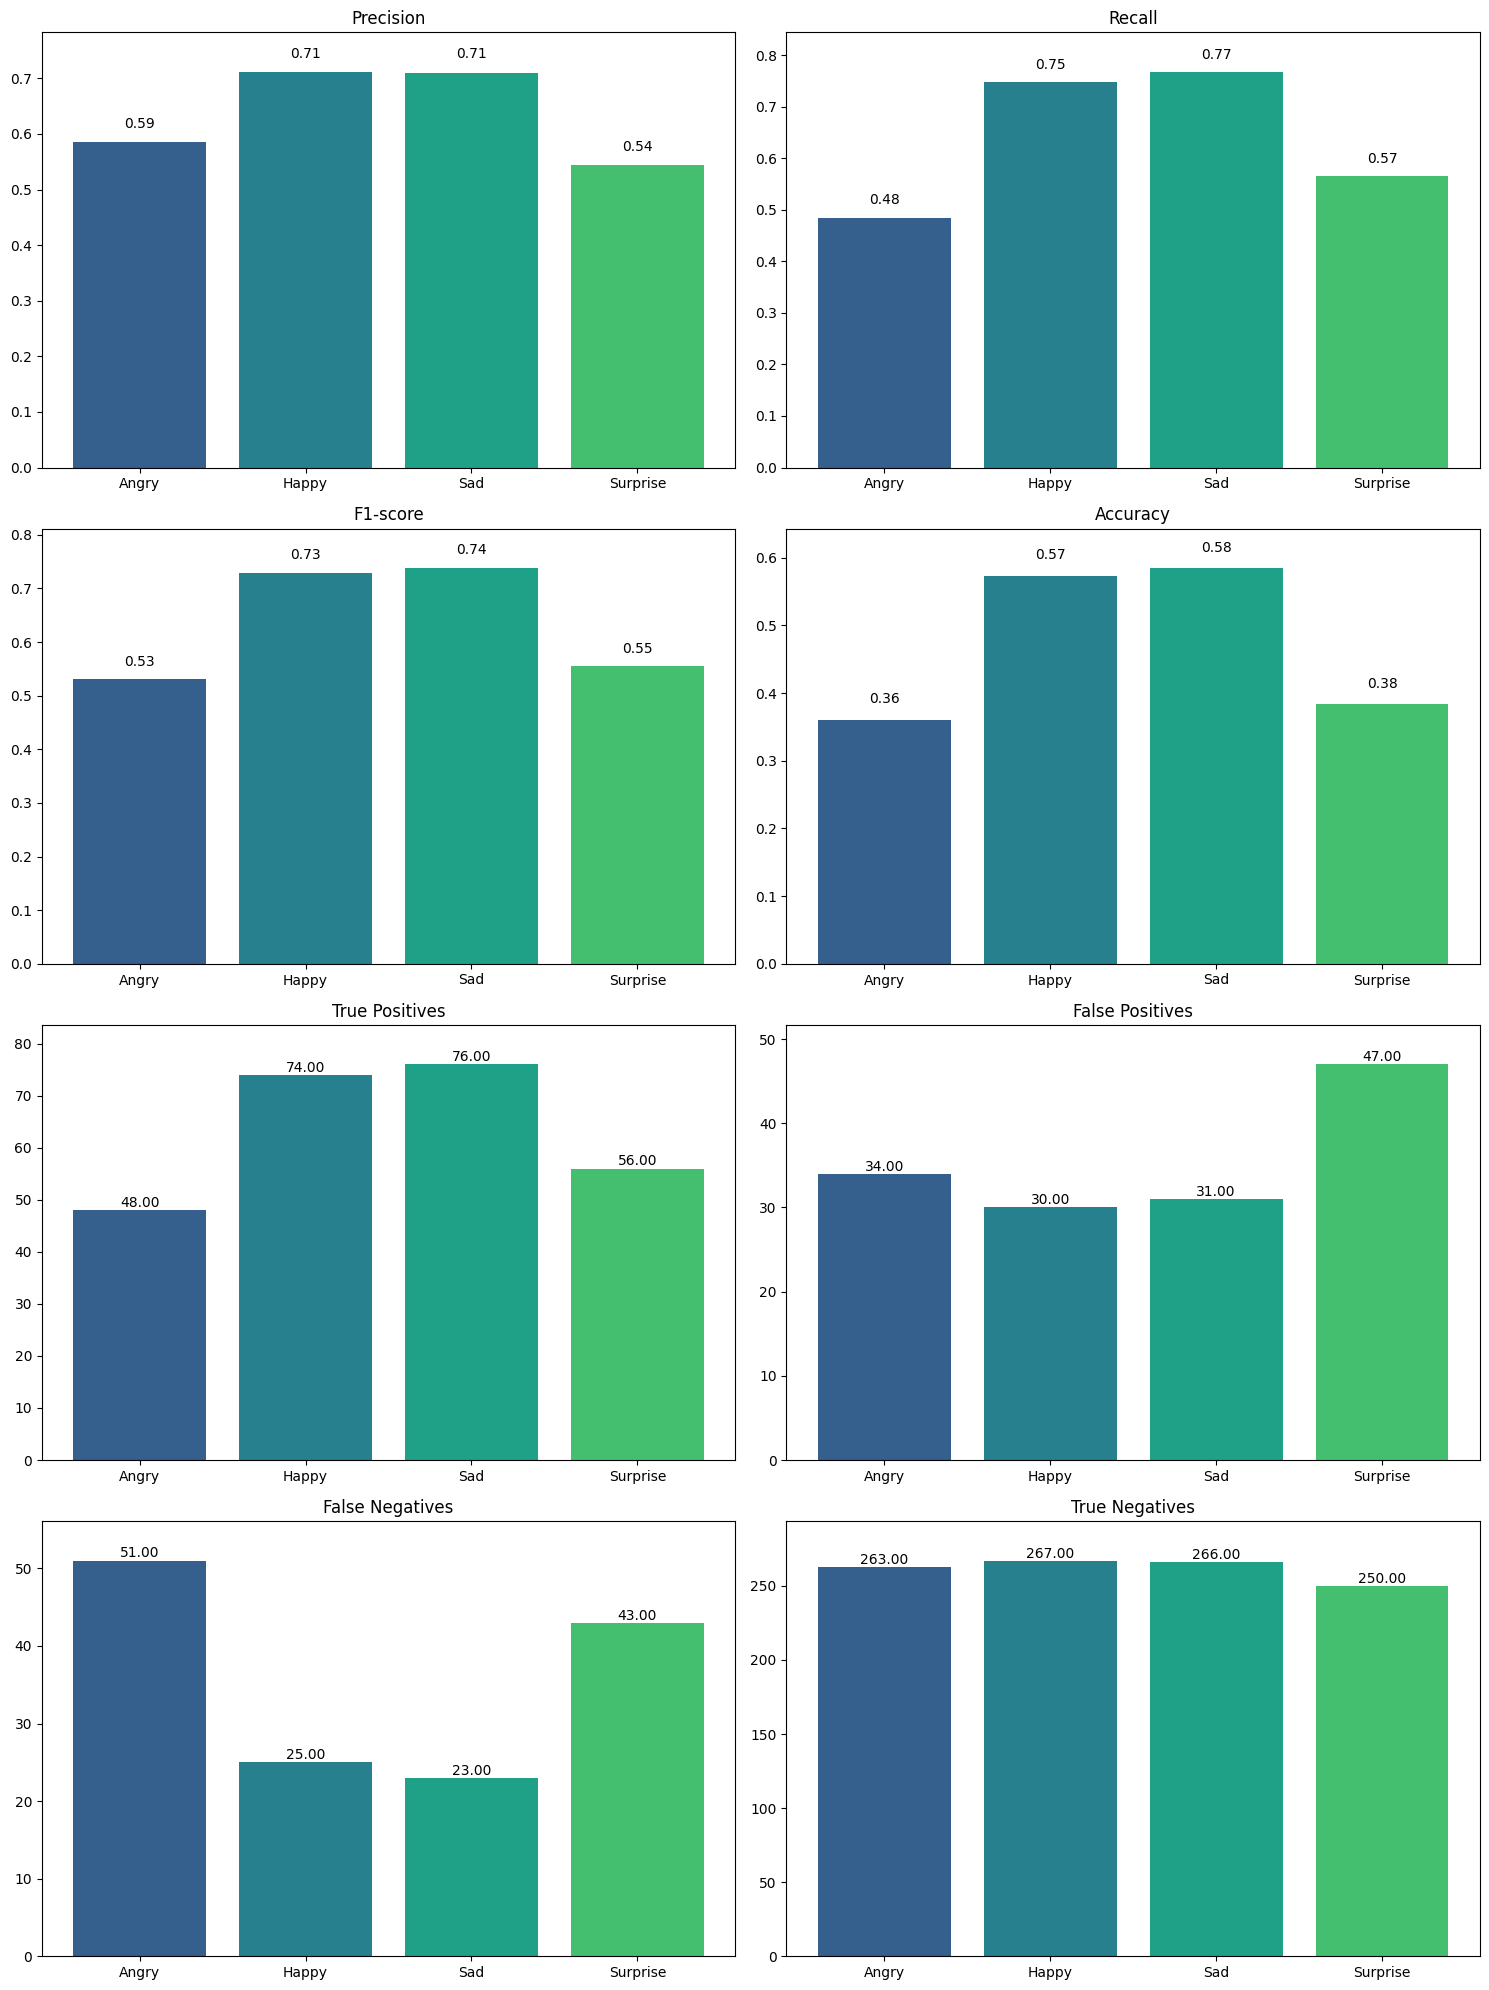

In [26]:
plot_accuracy_report(detailed_accuracy_report_beasc)

In [27]:
beasc_local_explanations_angry, beasc_explanation_data_angry = get_local_explanations(beasc_opensmile_ebm, beasc_x_test, beasc_y_test, 'Angry')
contributions_dict_beasc_angry = build_contributions_dict(beasc_explanation_data_angry)

In [28]:
def plot_top_5_features(dict1, dict2, dict3):
    # Function to extract the top 5 keys based on absolute values
    def get_top_5_features(d):
        return sorted(d.items(), key=lambda x: x[1], reverse=True)[:5]

    # Get the top 5 features for each dictionary
    top_features_dict1 = get_top_5_features(dict1)
    top_features_dict2 = get_top_5_features(dict2)
    top_features_dict3 = get_top_5_features(dict3)

    # Extracting keys and values for plotting
    keys1, values1 = zip(*top_features_dict1)
    keys2, values2 = zip(*top_features_dict2)
    keys3, values3 = zip(*top_features_dict3)

    # Creating subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting each set of features
    ax[0].barh(keys1, values1, color='skyblue')
    ax[0].set_title('Top 5 Features by median of CREMA-d ')
    ax[1].barh(keys2, values2, color='lightgreen')
    ax[1].set_title('Top 5 Features by median of emodb')
    ax[2].barh(keys3, values3, color='salmon')
    ax[2].set_title('Top 5 Features by median of BEASC')

    # Improving layout
    plt.tight_layout()
    plt.show()

In [29]:
crema_local_explanations_sad, crema_explanation_data_sad = get_local_explanations(crema_ebm, crema_x_test, crema_y_test, 'sad')
contributions_dict_crema_sad = build_contributions_dict(crema_explanation_data_sad)

In [30]:
emodb_local_explanations_sad, emodb_explanation_data_sad = get_local_explanations(emodb_opensmile_ebm, emodb_x_test, emodb_y_test, 'sadness')
# Example usage for building and plotting feature contributions for emodb
contributions_dict_emodb_sad = build_contributions_dict(emodb_explanation_data_sad)

In [31]:
beasc_local_explanations_sad, beasc_explanation_data_sad = get_local_explanations(beasc_opensmile_ebm, beasc_x_test, beasc_y_test, 'Sad')
contributions_dict_beasc_sad = build_contributions_dict(beasc_explanation_data_sad)

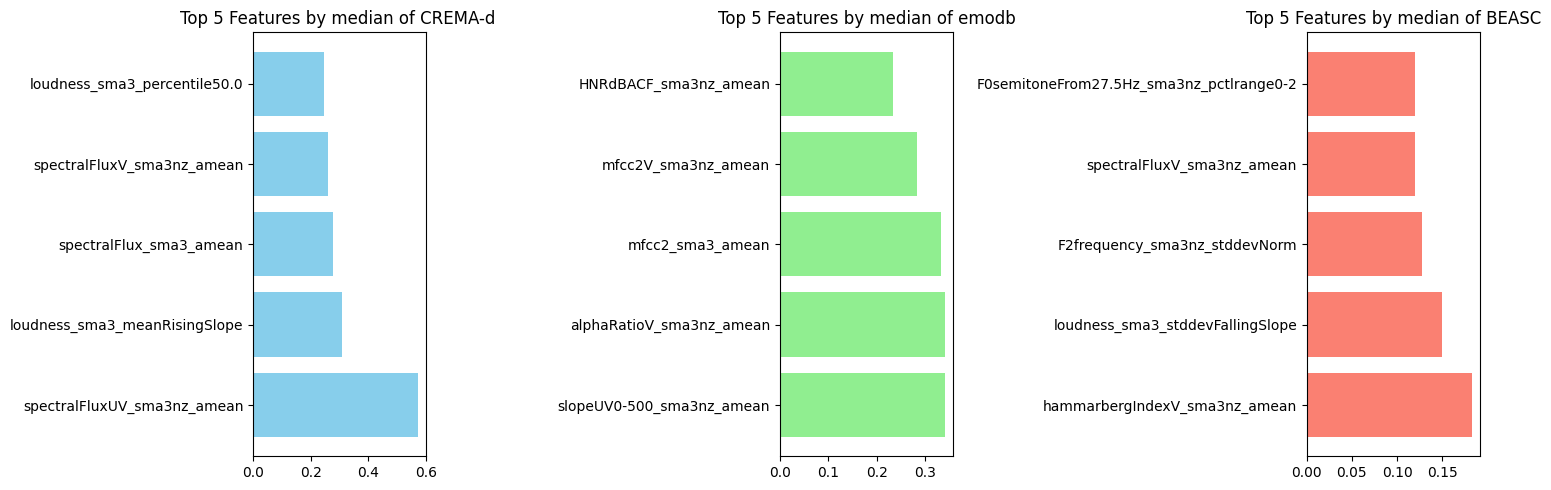

In [32]:
plot_top_5_features(calculate_median_contributions(contributions_dict_crema_angry), calculate_median_contributions(contributions_dict_emodb_angry), calculate_median_contributions(contributions_dict_beasc_angry))

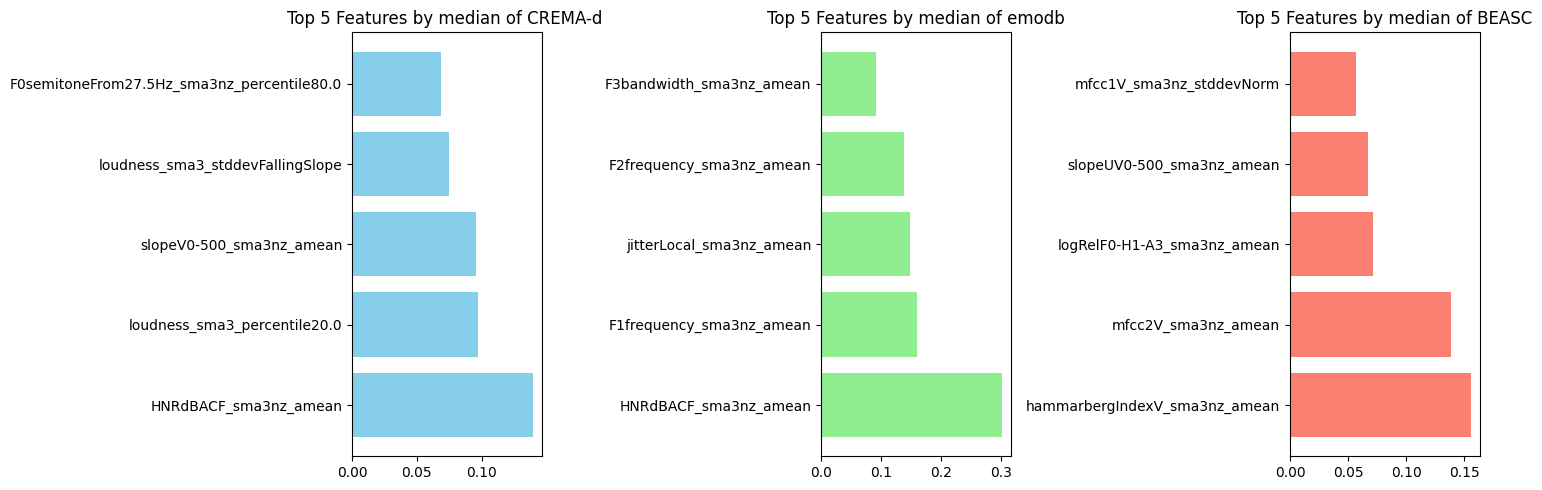

In [33]:
plot_top_5_features(calculate_median_contributions(contributions_dict_crema_sad), calculate_median_contributions(contributions_dict_emodb_sad), calculate_median_contributions(contributions_dict_beasc_sad))